Categorical Ordinary Least-Squares 
====

## Unit 12, Lecture 3

*Numerical Methods and Statistics*

----

#### Prof. Andrew White, April 25 2017

Goals:
---

1. Regress on categorical data
2. Learn that unordered categories have to be split into dummy variables
3. Know when to test interaction variables

In [1]:
%matplotlib inline
import random
import numpy as np
import matplotlib.pyplot as plt
from math import sqrt, pi, erf
import seaborn
seaborn.set_context("talk")
#seaborn.set_style("white")
import scipy.stats

Regression with discrete domains
===

Let's say we have a potential drug molecule that improves your test-taking abilities. We give 10 people the drug and 7 are given a plcebo. Here's their results on an exam:

Drug Group | Control Group
---------- | ---------:|
35 | 27
38 | 29
25 | 34
34 | 32
42 | 35
41 | 22
27 | 19
32 |
43 |
36 |

Did the drug make a difference?

We know how to solve this from hypothesis testing - Wilcoxon Sum of Ranks

In [2]:
import scipy.stats as boop

drug = np.array([35, 38, 25 , 34, 42, 41 , 27, 32, 43, 36])
control = np.array([27, 29, 34 , 32, 35 , 22, 19])

boop.ranksums(drug, control)

RanksumsResult(statistic=2.0493901531919199, pvalue=0.040423979336908521)

Let's try regressing it! To regress, we need two dimensions. Right now we only have one. Let's create a *category* or *dummy* variable indicating if the exam score came from the drug or control group:

In [3]:
drugged = np.concatenate( (np.ones(10), np.zeros(7)) )
exam = np.concatenate( (drug, control) )

print(np.column_stack( (drugged, exam) ) )

[[  1.  35.]
 [  1.  38.]
 [  1.  25.]
 [  1.  34.]
 [  1.  42.]
 [  1.  41.]
 [  1.  27.]
 [  1.  32.]
 [  1.  43.]
 [  1.  36.]
 [  0.  27.]
 [  0.  29.]
 [  0.  34.]
 [  0.  32.]
 [  0.  35.]
 [  0.  22.]
 [  0.  19.]]


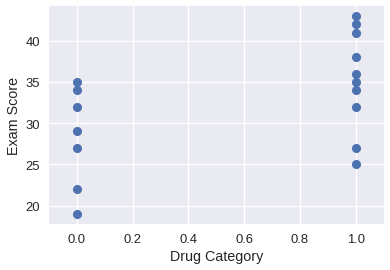

In [4]:
plt.plot(drugged, exam, 'o')
plt.xlim(-0.1, 1.1)
plt.xlabel('Drug Category')
plt.ylabel('Exam Score')
plt.show()

It looks like we can indeed regress this data! The equation we're modeling is this:

$$y = \beta_0 + \beta_1 \delta_d + \epsilon $$


In [5]:
dof = len(drugged) - 2
cov = np.cov(drugged, exam, ddof=2)
slope = cov[0,1] / cov[0,0]
intercept = np.mean(exam - slope * drugged)

print(slope, intercept)

7.01428571429 28.2857142857


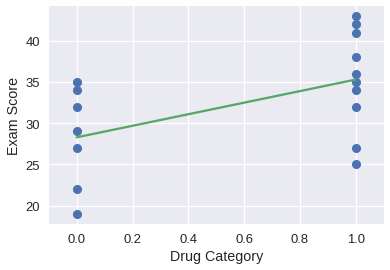

In [6]:
plt.plot(drugged, exam, 'o')
plt.plot(drugged, slope * drugged + intercept, '-')
plt.xlim(-0.1, 1.1)
plt.xlabel('Drug Category')
plt.ylabel('Exam Score')
plt.show()

Well that's interesting. But can we get a $p$-value out of this? We can, by seeing if the slope is necessary. Let's take the null hypothesis to be that $\beta_1 = 0$

In [7]:
s2_e = np.sum( (exam - slope * drugged - intercept)**2 ) / dof
s2_b = s2_e / np.sum( (drugged - np.mean(drugged)) ** 2 )

slope_se = np.sqrt(s2_b)
T = slope / slope_se

#The null hypothesis is that you have no slope, so DOF = N - 1
2 * (1 - boop.t.cdf(T, len(drugged) - 1))

0.032106398987899132

We get a $p$-value of $0.032$, which is quite close to what the sum of ranks test gave. However, we can now do more dimensions than the sum of ranks test.

Multiple Categories
---

Now let's say that I'm studying plant growth and I have two categories: I fertilized the plant and I put the plant in direct sunlight. Let's turn that into two variables: $\delta_s$ for sunlight and $\delta_f$ for fertilizer. 

Now you might believe that there is an *interaction* between these two *factors*. That is, having sunlight and fertilizer has an effect beyond the sum of the two individually. I can write this as $\delta_{fs}$. This category is 1 when both fertilizer and direct sunlight is provided. It turns out:

$$\delta_{fs} = \delta_s \times \delta_f $$

Our model equation will then be:
    
$$ g = \beta_0 + \beta_s \delta_s + \beta_f \delta_f + \beta_{sf} \delta_s \delta_f + \epsilon$$

and here's some data

In [8]:
growth = [13.4,11.4, 11.9, 13.1, 14.8, 12.0, 14.3, 13.2, 13.4, 12.2, 1.9, 3.1, 4.4, 3.9, 4.2, 3.2, 2.1, 2.1, 3.4, 4.2, 5.6, 4.5, 4.7, 6.9, 5.1, 3.2, 2.7, 5.2, 5.4, 4.9, 3.5, 2.3, 3.4, 5.4, 4.1, 4.0, 3.2, 4.1, 3.3, 3.4]
fertilizer = [1.0,1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
sunlight = [1.0,1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

In [9]:
print(np.column_stack((fertilizer, sunlight, growth)))

[[  1.    1.   13.4]
 [  1.    1.   11.4]
 [  1.    1.   11.9]
 [  1.    1.   13.1]
 [  1.    1.   14.8]
 [  1.    1.   12. ]
 [  1.    1.   14.3]
 [  1.    1.   13.2]
 [  1.    1.   13.4]
 [  1.    1.   12.2]
 [  1.    0.    1.9]
 [  1.    0.    3.1]
 [  1.    0.    4.4]
 [  1.    0.    3.9]
 [  1.    0.    4.2]
 [  1.    0.    3.2]
 [  1.    0.    2.1]
 [  1.    0.    2.1]
 [  1.    0.    3.4]
 [  1.    0.    4.2]
 [  0.    1.    5.6]
 [  0.    1.    4.5]
 [  0.    1.    4.7]
 [  0.    1.    6.9]
 [  0.    1.    5.1]
 [  0.    1.    3.2]
 [  0.    1.    2.7]
 [  0.    1.    5.2]
 [  0.    1.    5.4]
 [  0.    1.    4.9]
 [  0.    0.    3.5]
 [  0.    0.    2.3]
 [  0.    0.    3.4]
 [  0.    0.    5.4]
 [  0.    0.    4.1]
 [  0.    0.    4. ]
 [  0.    0.    3.2]
 [  0.    0.    4.1]
 [  0.    0.    3.3]
 [  0.    0.    3.4]]


You can see we have 10 examples of each possible combination of categories. Let's now regress it using multidimensional least squares. Our columns will be $[1, \delta_s, \delta_f, \delta_s \delta_f] $, so we'll be doing 4-dimensional regression.

In [10]:
N = len(growth)
dof = N - 4

x_mat = np.column_stack( (np.ones(N), sunlight, fertilizer, np.array(sunlight) * np.array(fertilizer)) )
print(x_mat)

[[ 1.  1.  1.  1.]
 [ 1.  1.  1.  1.]
 [ 1.  1.  1.  1.]
 [ 1.  1.  1.  1.]
 [ 1.  1.  1.  1.]
 [ 1.  1.  1.  1.]
 [ 1.  1.  1.  1.]
 [ 1.  1.  1.  1.]
 [ 1.  1.  1.  1.]
 [ 1.  1.  1.  1.]
 [ 1.  0.  1.  0.]
 [ 1.  0.  1.  0.]
 [ 1.  0.  1.  0.]
 [ 1.  0.  1.  0.]
 [ 1.  0.  1.  0.]
 [ 1.  0.  1.  0.]
 [ 1.  0.  1.  0.]
 [ 1.  0.  1.  0.]
 [ 1.  0.  1.  0.]
 [ 1.  0.  1.  0.]
 [ 1.  1.  0.  0.]
 [ 1.  1.  0.  0.]
 [ 1.  1.  0.  0.]
 [ 1.  1.  0.  0.]
 [ 1.  1.  0.  0.]
 [ 1.  1.  0.  0.]
 [ 1.  1.  0.  0.]
 [ 1.  1.  0.  0.]
 [ 1.  1.  0.  0.]
 [ 1.  1.  0.  0.]
 [ 1.  0.  0.  0.]
 [ 1.  0.  0.  0.]
 [ 1.  0.  0.  0.]
 [ 1.  0.  0.  0.]
 [ 1.  0.  0.  0.]
 [ 1.  0.  0.  0.]
 [ 1.  0.  0.  0.]
 [ 1.  0.  0.  0.]
 [ 1.  0.  0.  0.]
 [ 1.  0.  0.  0.]]


In [12]:
import scipy.linalg as linalg

#I'll use the lstsq convienence function
#It gives back a bunch of stuff I don't want though
#I'll throw it away by assigning it all the an underscore
beta,*_ = linalg.lstsq(x_mat, growth)

print(beta)

[ 3.67  1.15 -0.42  8.57]


That tells us about what you'd expect: the combination is quite important! Let's get individual confidence intervals on the factors

In [13]:
s2_e = np.sum( (growth - x_mat.dot(beta))**2 ) / dof
s2_b = linalg.inv(x_mat.transpose().dot(x_mat)) * s2_e
s_b = np.sqrt(np.diag(s2_b))

names = ['beta_0', 'beta_s', 'beta_f', 'beta_sf']
for bi, si, ni in zip(beta, s_b, names):
    print('{}: {} +/- {}'.format(ni, bi, si * boop.t.ppf(0.975, dof)))

beta_0: 3.670000000000003 +/- 0.6535426058182527
beta_s: 1.1499999999999977 +/- 0.9242488167368267
beta_f: -0.41999999999999926 +/- 0.9242488167368267
beta_sf: 8.570000000000004 +/- 1.3070852116365055


We could go farther and justify the existence of the coefficients. As you can see from the confidence intervals, the $\beta_s$ and/or $\beta_f$ may be unnecessary.

Some notes on our regression
---

What we've learned about so far is part of a large field: the design and analysis of experiments with statistics. We've used simple analysis, hypothesis tests on existence of coefficeints, but that is not the most robust measure. For example, if two coefficients are unneeded, do you remove both or one at a time? A better way is to use an *Analysis of Variance* (ANOVA) and *F-test*, a hypothesis test for comparing models. You can find more information on this in your Langley statistics book. 

Unordered categorical data
===

When working with categorical data that has more than one category, but they are unordered, you must create a series of dummy variables. For example, if your category is color from three possibilities: `red`, `blue`, `orange`, it's *incorrect* to assign a number to each color. This would induce an ordering and imply that `red` is greater than `blue` or vice-versa. 

You should instead create dummy variables for each value in the category:

$$
[\delta_{\textrm{red}}, \delta_{\textrm{blue}}, \delta_{\textrm{orange}}]
$$